
# **Name- Shirish Bajracharya**
# **Batch- JULY 2022**
# **GRIP @ THE SPARKS FOUNDATION**


# **TASK-7 Stock Market Prediction using Numerical and Textual Analysis**
(Level - Advanced)


* Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.
* Stock to analyze and predict SENSEX (S&P BSE SENSEX).
* Use either R or Python, or both for separate analysis and then combine the findings to create a hybrid model.

*Importing Necessary Librarires*

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mounting drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd "/content/drive/My Drive/TSFINTERN/Task 7"

/content/drive/My Drive/TSFINTERN/Task 7


# TIME SERIES ANALYSIS

In [5]:
df_prices = pd.read_csv('bsesn.csv')
print(df_prices.head())
print(df_prices.size)

   Unnamed: 0        Date          Open          High           Low  \
0           0  2017-07-19  31882.800781  31978.890625  31793.720703   
1           1  2017-07-20  32033.820313  32057.119141  31859.500000   
2           2  2017-07-21  32035.880859  32062.230469  31808.929688   
3           3  2017-07-24  32100.220703  32320.859375  32058.330078   
4           4  2017-07-25  32350.710938  32374.300781  32196.859375   

          Close     Adj Close   Volume  
0  31955.349609  31955.349609  11300.0  
1  31904.400391  31904.400391  11200.0  
2  32028.890625  32028.890625  18000.0  
3  32245.869141  32245.869141  11500.0  
4  32228.269531  32228.269531  14100.0  
9888


*Converting Date column to datetime datatype*

In [6]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1236 non-null   int64         
 1   Date        1236 non-null   datetime64[ns]
 2   Open        1231 non-null   float64       
 3   High        1231 non-null   float64       
 4   Low         1231 non-null   float64       
 5   Close       1231 non-null   float64       
 6   Adj Close   1231 non-null   float64       
 7   Volume      1231 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 77.4 KB


In [7]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

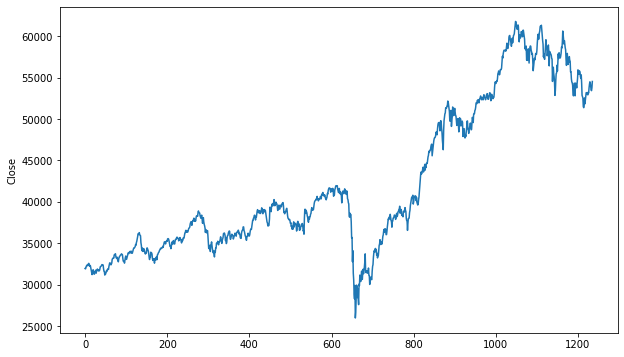

In [8]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

*Plotting moving average*

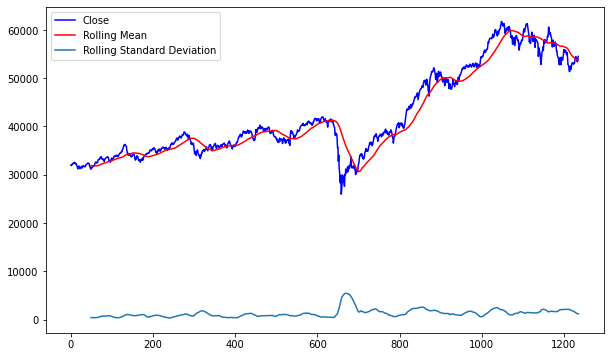

In [9]:
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

*Plotting returns*

Text(0.5, 1.0, 'Returns')

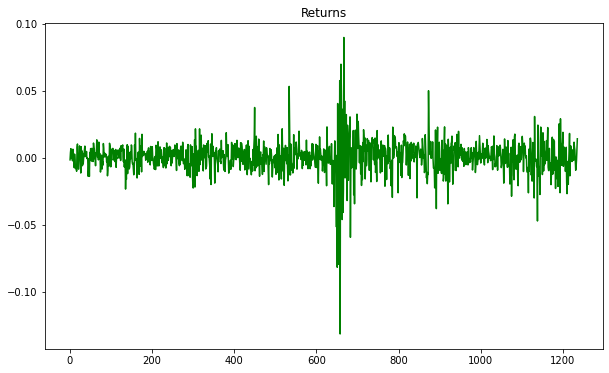

In [10]:
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [11]:
train = df_prices[:1000]
test = df_prices[1000:]

*Stationarity test*

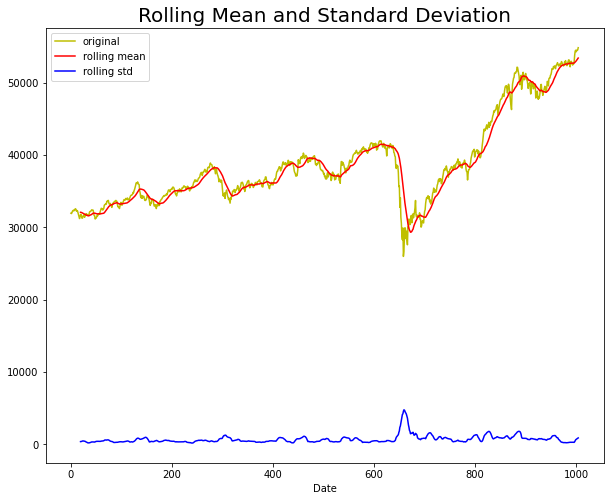

Results of dickey fuller test
ADF Test Statistic : -0.1339725315689044
p-value : 0.9459478364141646
#Lags Used : 11
Number of Observations Used : 988
Weak evidence against null hypothesis, time series is non-stationary 


In [12]:
def test_stationarity(timeseries):
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

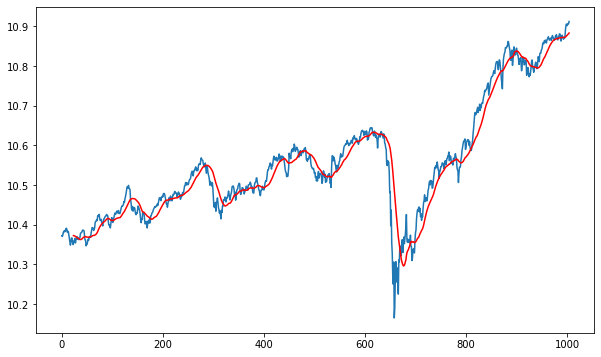

In [13]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

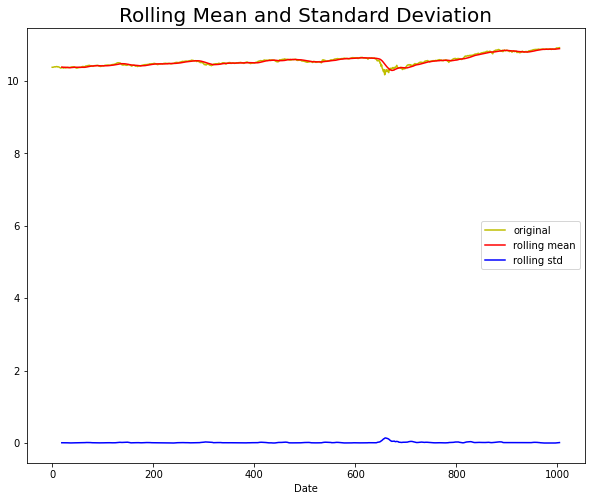

Results of dickey fuller test
ADF Test Statistic : -0.7075665076196433
p-value : 0.8447798947741293
#Lags Used : 11
Number of Observations Used : 988
Weak evidence against null hypothesis, time series is non-stationary 


In [14]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

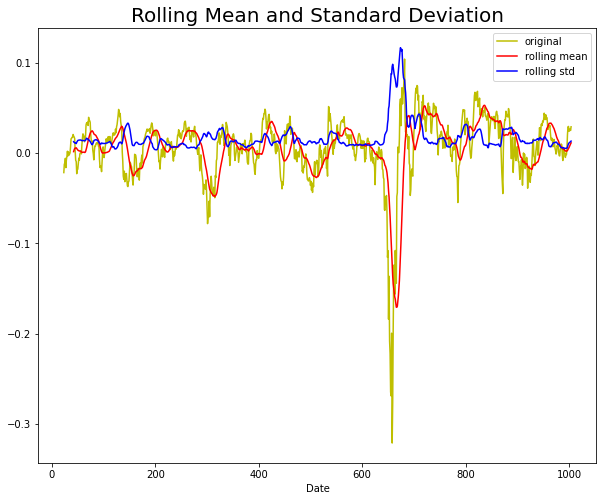

Results of dickey fuller test
ADF Test Statistic : -6.202256174263906
p-value : 5.769226791196647e-08
#Lags Used : 12
Number of Observations Used : 964
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [15]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

*Using auto arima to make predictions using log data*

In [16]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5892.254, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5895.239, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5897.443, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5897.191, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5895.410, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5896.248, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5895.840, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5894.618, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5897.367, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.048 seconds


Text(0, 0.5, 'Actual Stock Price')

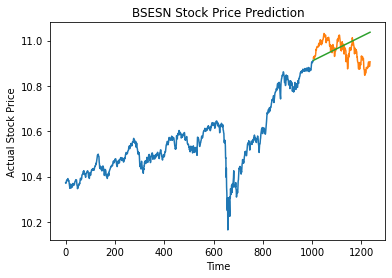

In [17]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

*Calculating error*

In [18]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.07551916794992479


**TEXTUAL ANALYSIS**

In [19]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [20]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 83.6+ MB


*Converting data type of Date column*

In [21]:
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3650966,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
3650967,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,2022-03-31,As Covid-19 cases drop to nil in southern dist...
3650969,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


*Grouping the headlines for each day*

In [22]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [23]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7712    Playing a dead man in Body God meant sitting i...
7713    As fashion becomes democratic; demand for styl...
7714    Bobby Deol: Like my dad; I hope to be working ...
7715    I will not give in to trends: Dossmode The tim...
7716    Shashank goes back to coastal Karnataka and Mo...
Name: News, Length: 7717, dtype: object

*Cleaning headlines*

In [24]:
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    ps = PorterStemmer()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [25]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
1,2001-01-03,powerless north india grope dark think laxman ...
2,2001-01-04,string pull stephen hawk india vajpaye give bi...
3,2001-01-05,light combat craft take india club class hawk ...
4,2001-01-06,light combat craft take india club class hawk ...
...,...,...
7712,2022-03-27,play dead man bodi god meant sit refriger guru...
7713,2022-03-28,fashion becom democrat demand stylist soar las...
7714,2022-03-29,bobbi deol like dad hope work age yasha surya ...
7715,2022-03-30,give trend dossmod time gave boyfriend incred ...


*Functions to get the subjectivity and polarity*

In [26]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

*Adding subjectivity and polarity columns*

In [27]:
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
7712,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855
7713,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270
7714,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037
7715,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339


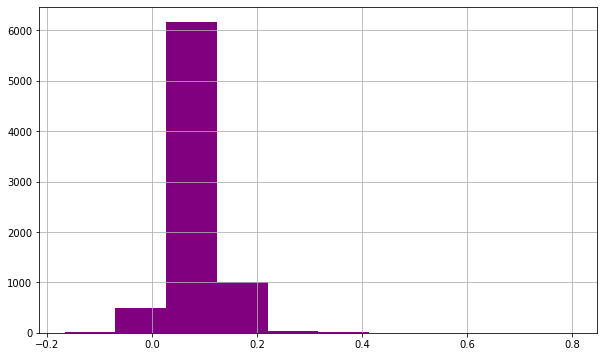

In [28]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

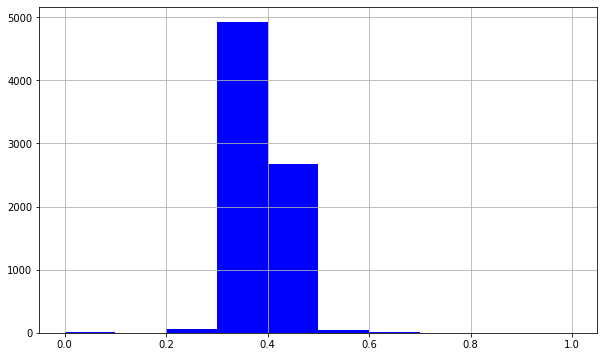

In [29]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

*Adding sentiment score to df_news*

In [30]:
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
7712,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855,-0.9999,0.149,0.782,0.069
7713,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270,-0.9998,0.144,0.778,0.078
7714,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037,-0.9997,0.129,0.799,0.072
7715,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339,-0.9998,0.139,0.794,0.067


In [31]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0,2017-07-19,31882.800781,31978.890625,31793.720703,31955.349609,31955.349609,11300.0,big name india us inc root independ us india b...,0.375974,0.021692,-0.9999,0.161,0.758,0.080
1,1,2017-07-20,32033.820313,32057.119141,31859.500000,31904.400391,31904.400391,11200.0,new zuari bridg miss deadlin recoveri lucki se...,0.351111,0.073642,-0.9992,0.124,0.776,0.100
2,2,2017-07-21,32035.880859,32062.230469,31808.929688,32028.890625,32028.890625,18000.0,rp exercis start scratch base rp micro review ...,0.351129,0.049974,-0.9997,0.132,0.776,0.091
3,3,2017-07-24,32100.220703,32320.859375,32058.330078,32245.869141,32245.869141,11500.0,stop arteri blockag key healthi heart gsl deli...,0.375890,0.077818,-0.9998,0.140,0.771,0.089
4,4,2017-07-25,32350.710938,32374.300781,32196.859375,32228.269531,32228.269531,14100.0,man set wife fire suspect fidel kiara advani s...,0.392433,0.041458,-0.9999,0.150,0.767,0.083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,1157,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900.0,speed shortcut tackl unruli custom take deliv ...,0.377083,0.026320,-0.9999,0.146,0.795,0.059
1153,1158,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300.0,fashion becom democrat demand stylist soar las...,0.382331,0.079270,-0.9998,0.144,0.778,0.078
1154,1159,2022-03-29,57814.761719,58001.531250,57639.351563,57943.648438,57943.648438,12100.0,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037,-0.9997,0.129,0.799,0.072
1155,1160,2022-03-30,58362.851563,58727.781250,58176.000000,58683.988281,58683.988281,6300.0,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339,-0.9998,0.139,0.794,0.067


In [32]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,31955.349609,0.375974,0.021692,-0.9999,0.161,0.758,0.080
1,31904.400391,0.351111,0.073642,-0.9992,0.124,0.776,0.100
2,32028.890625,0.351129,0.049974,-0.9997,0.132,0.776,0.091
3,32245.869141,0.375890,0.077818,-0.9998,0.140,0.771,0.089
4,32228.269531,0.392433,0.041458,-0.9999,0.150,0.767,0.083
...,...,...,...,...,...,...,...
1152,57362.199219,0.377083,0.026320,-0.9999,0.146,0.795,0.059
1153,57593.488281,0.382331,0.079270,-0.9998,0.144,0.778,0.078
1154,57943.648438,0.372864,0.083037,-0.9997,0.129,0.799,0.072
1155,58683.988281,0.330696,0.052339,-0.9998,0.139,0.794,0.067


In [33]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.166948,0.301192,0.110142,0.00005,0.740741,0.239316,0.485294
1,0.165524,0.195663,0.273531,0.00040,0.398148,0.393162,0.779412
2,0.169003,0.195740,0.199093,0.00015,0.472222,0.393162,0.647059
3,0.175066,0.300838,0.286668,0.00010,0.546296,0.350427,0.617647
4,0.174574,0.371054,0.172307,0.00005,0.638889,0.316239,0.529412


In [34]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [35]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.301192,0.110142,0.00005,0.740741,0.239316,0.485294
1,0.195663,0.273531,0.00040,0.398148,0.393162,0.779412
2,0.195740,0.199093,0.00015,0.472222,0.393162,0.647059
3,0.300838,0.286668,0.00010,0.546296,0.350427,0.617647
4,0.371054,0.172307,0.00005,0.638889,0.316239,0.529412


In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(925, 6)

In [37]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
487,0.267989,0.332583,0.00010,0.537037,0.444444,0.470588
397,0.190989,0.330174,0.00015,0.425926,0.615385,0.352941
707,0.324493,0.231404,0.00010,0.546296,0.470085,0.411765
994,0.241077,0.164957,0.00010,0.546296,0.487179,0.367647
196,0.406947,0.326671,0.00005,0.787037,0.102564,0.661765
268,0.380751,0.287986,0.00040,0.277778,0.589744,0.632353
183,0.331189,0.353968,0.00005,0.750000,0.059829,0.794118
1006,0.333321,0.060713,0.00005,0.583333,0.504274,0.294118
395,0.366749,0.212730,0.00010,0.574074,0.504274,0.308824
528,0.315487,0.367349,0.00025,0.379630,0.547009,0.544118


In [38]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [39]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.69470504 0.67375682 0.57872164 0.28358619 0.54542896 0.50474235
 0.27646345 0.26046158 0.75200121 0.22952411]
1084    0.892007
1038    0.952311
840     0.586274
317     0.221043
1053    0.954530
924     0.626119
587     0.408013
294     0.298198
760     0.359449
270     0.334410
Name: Close, dtype: float64
0.04378517552839184


In [40]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [41]:
print(mean_squared_error(predictions, y_test))

0.04700729376773106


In [42]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [43]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.89840138 0.75116468 0.75294924 0.28138561 0.7425115  0.42403679
 0.28295218 0.24940705 0.74860911 0.16900266]
1084    0.892007
1038    0.952311
840     0.586274
317     0.221043
1053    0.954530
924     0.626119
587     0.408013
294     0.298198
760     0.359449
270     0.334410
Name: Close, dtype: float64
0.07711063447103625


In [44]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [45]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.05383104790619369


In [46]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[15:37:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [47]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.045429749259567706


**Conclusion**

We observe that Xgboost model performs the best for the sentiment analysis

**Thankyou**


---



---

